# CNN Prediction

In [7]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [26]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [27]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)

In [28]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [29]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

In [30]:
def pred_roc_data(model, img, label_one_hot):
    pred_keras = model.predict(img).ravel() # ravel(): Flatten the array
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_one_hot.ravel(), pred_keras) 
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, auc_keras

# Processing

In [16]:
img_width, img_height = 224, 224

In [ ]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

In [ ]:
# ## For rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_dup_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_dup_image_info.list'

In [ ]:
# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

In [ ]:
# ## For splited rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [ ]:
# true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [ ]:
# true_images_path_list  = true_cnv_df['image_path']
# false_images_path_list = false_cnv_df['image_path']

In [ ]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

### Loading images from list to numpy array

In [ ]:
# false_img_np = loadImgs(false_images_path_list, img_width, img_height)
# false_img_np.shape

In [ ]:
# true_img_np = loadImgs(true_images_path_list, img_width, img_height)
# true_img_np.shape

### Generage labels

In [ ]:
# true_label = [1 for i in range(0,len(true_img_np))]
# false_label = [0 for i in range(0,len(false_img_np))]
# print(true_label[0:5], false_label[0:5])
# print(len(true_label), len(false_label))

### Combine true & false data

In [ ]:
# combined_cnv_info_df = true_cnv_df.append(false_cnv_df, ignore_index=True)
# #combined_cnv_info_index = list(range(len(combined_cnv_info_df)))
# combined_img_np = np.vstack((true_img_np, false_img_np))
# combined_label = true_label + false_label

In [ ]:
# combined_cnv_info_df.shape, true_cnv_df.shape, false_cnv_df.shape

### Backup or restore

In [17]:
backup_path = '/home/rt2776/cnv_espresso/images_rare/data_backup/'
# os.makedirs(backup_path, exist_ok=True)

In [18]:
## Backup

# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

# project_name = 'rare_entire_dup'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
# np.save(backup_path+'rare_entire_dup_img', combined_img_np)
# np.save(backup_path+'rare_entire_dup_label', combined_label)

In [69]:
## Restore for entire del or dup

# project_name = 'rare_entire_del'
project_name = 'rare_entire_dup'

if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
    combined_img_np = np.load(backup_path + project_name + '_img.npy')
    combined_label = np.load(backup_path + project_name + '_label.npy')
    combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

In [70]:
## Restore for split del or dup

# project_name = 'rare_split_del'
# project_name = 'rare_split_dup'

if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
    combined_img_np = np.load(backup_path + project_name + '_img.npy')
    combined_label  = np.load(backup_path + project_name + '_label.npy')
    try:
        del combined_cnv_info_df
    except:
        pass

In [71]:
print("Project: '%s' dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img_np.shape)
print("  -- Shape of label      : ", combined_label.shape)
try:
    print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
except:
    print("There is no CNV info data for split del or dup.")

Project: 'rare_entire_dup' dataset loaded.
  -- Shape of image array:  (15839, 224, 224, 3)
  -- Shape of label      :  (15839,)
  -- Shape of CNV info   :  (15839, 22)


## Split dataset into training(80%) and testing(20%) dataset

In [72]:
## split image arrays
if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
    train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img_np,
                                                                                                        combined_label,
                                                                                                        combined_cnv_info_df,
                                                                                                        test_size=0.2,
                                                                                                        shuffle=True,
                                                                                                        random_state=3)

    train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                      train_label,
                                                                                                      train_cnv_info_df,
                                                                                                      test_size=0.25,
                                                                                                      shuffle=True,
                                                                                                      random_state=3) # 0.25*0.8=0.2

In [73]:
## split image arrays for splits CNVs

if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
    train_img, test_img, train_label, test_label = train_test_split(combined_img_np,
                                                                    combined_label,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    random_state=3)

    train_img, val_img, train_label, val_label = train_test_split(train_img,
                                                                  train_label,
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=3) # 0.25*0.8=0.2

(None,
 1,
 Unnamed: 0                                                                  1650
 CHR                                                                            7
 PRED_START                                                             101321670
 PRED_END                                                               101447787
 TYPE                                                                         DUP
 SAMPLE                                                                 SP0025124
 CANOES_RT                                                                      0
 CLAMMS_RT                                                                   0.22
 XHMM_RT                                                                        1
 NUM_OVERLAPS_RT                                                                2
 RD_PROP_RT                                                                   1.8
 GC                                                                           0.5
 PRED

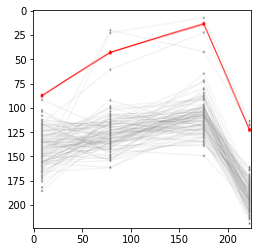

In [74]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
showImg(combined_img_np[i]),combined_label[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]

(None,
 1,
 Unnamed: 0                                                                   314
 CHR                                                                           13
 PRED_START                                                              75537381
 PRED_END                                                                75537805
 TYPE                                                                         DUP
 SAMPLE                                                                 SP0006076
 CANOES_RT                                                                      0
 CLAMMS_RT                                                                      0
 XHMM_RT                                                                        1
 NUM_OVERLAPS_RT                                                                1
 RD_PROP_RT                                                                  2.05
 GC                                                                          0.59
 PRED

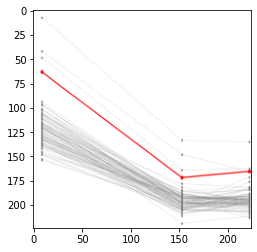

In [75]:
showImg(train_img[i]),train_label[i],train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]

In [76]:
print(test_img.shape, test_label.shape)
print(test_label[0:200])

(3168, 224, 224, 3) (3168,)
[1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1
 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0
 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1
 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0]


## Normalization

In [77]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [78]:
# Change to float datatype
train_img = train_img.astype('float32')
val_img   = val_img.astype('float32')
test_img  = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
val_img   /= 255
test_img  /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
val_labels_one_hot   = to_categorical(val_label)
test_labels_one_hot  = to_categorical(test_label)

In [79]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [80]:
#np.where(test_label==0)

1


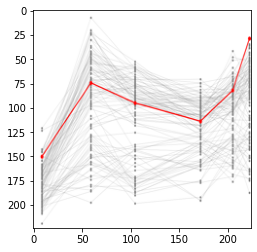

In [81]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### ROC curve

In [82]:
print(project_name)

rare_entire_dup


In [83]:
## Load pre-calculated model
common_cnn_model_path = '/home/rt2776/cnv_espresso/src/' + project_name + '_model.h5'
common_cnn_model = keras.models.load_model(common_cnn_model_path)

MobileNet_model_path = '/home/rt2776/cnv_espresso/src/' + project_name + '_MobileNet_v1.h5'
MobileNet_model = keras.models.load_model(MobileNet_model_path)

ResNet50_model_path = '/home/rt2776/cnv_espresso/src/' + project_name + '_ResNet50.h5'
ResNet50_model = keras.models.load_model(ResNet50_model_path)

In [84]:
MobileNet_model.evaluate(test_img, test_labels_one_hot)

99/99 [==============================] - 4s 36ms/step - loss: 0.4558 - accuracy: 0.9157


[0.4558321237564087, 0.9157196879386902]

In [85]:
common_cnn_model.evaluate(test_img, test_labels_one_hot)

99/99 [==============================] - 4s 35ms/step - loss: 0.2723 - accuracy: 0.8939


[0.27227726578712463, 0.8939393758773804]

In [86]:
fpr_MobileNet, tpr_MobileNet, auc_MobileNet = pred_roc_data(MobileNet_model, test_img, test_labels_one_hot)
fpr_ResNet50,  tpr_ResNet50,  auc_ResNet50  = pred_roc_data(ResNet50_model,  test_img, test_labels_one_hot)
fpr_common_cnn,tpr_common_cnn,auc_common_cnn= pred_roc_data(common_cnn_model,test_img, test_labels_one_hot)

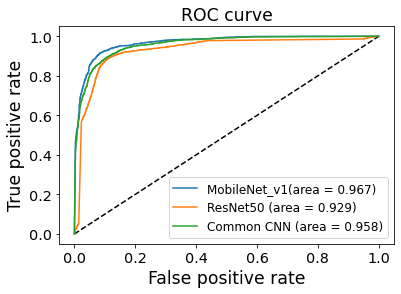

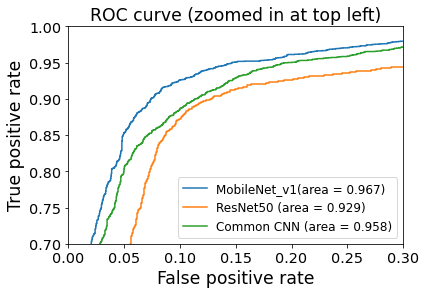

In [87]:
plt.figure(1) #,dpi=300
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

## Precision

In [102]:
model_name = "common_cnn"
model = common_cnn_model

# model_name = "MobileNet"
# model = MobileNet_model

# model = ResNet50_model

In [103]:
test_pred = model.predict(test_img)

In [104]:
test_output_df = copy.deepcopy(test_cnv_info_df)
test_output_df.shape

(3168, 22)

In [105]:
test_output_df.insert(test_output_df.shape[1], 'Prob_True', "")
test_output_df.insert(test_output_df.shape[1], 'Prob_False', "")
test_output_df.insert(test_output_df.shape[1], 'Prediction', "")
test_output_df.insert(test_output_df.shape[1], 'Pred_status', "")

In [106]:
test_output_df.shape,test_pred.shape, test_cnv_info_df.shape, len(test_cnv_info_df), test_img.shape

((3168, 26), (3168, 2), (3168, 22), 3168, (3168, 224, 224, 3))

In [107]:
num, correct_count = 0, 0
for i in range(len(test_pred)):
    num += 1
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_False')] = test_pred[i][0]
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_True')] = test_pred[i][1]

    if(np.argmax(test_pred[i]) == 0):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Negative"
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Positive"
        
    if(np.argmax(test_pred[i]) == test_label[i]):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Correct"
        correct_count += 1
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Wrong"
#     print(num, test_pred[i], test_label[i], pred_status)
score = correct_count/len(test_pred)
print('Accuracy for testing data: %.2f%s' % (score*100,'%'))

Accuracy for testing data: 89.39%


In [108]:
## output to file
output_path = '/home/rt2776/cnv_espresso/output/'
test_output_df.to_csv(output_path+project_name+'_'+model_name +'_test_predict_info.csv',index=False)

In [109]:
test_output_df[test_output_df['Pred_status']=='Wrong']

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path,Prob_True,Prob_False,Prediction,Pred_status
1118,1118,19,40807808,40850426,DUP,SP0017985,0.16,0.0,1.0,2,...,1,hg38,spark2,16,10,/home/rt2776/cnv_espresso/images_rare/true_dup...,0.373118,0.626881,Negative,Wrong
6852,6852,9,125149672,125160906,DUP,SP0091645,0.00,1.0,0.0,1,...,1,hg38,spark8,23,5,/home/rt2776/cnv_espresso/images_rare/true_dup...,0.409281,0.590719,Negative,Wrong
13131,13131,2,33523878,33555567,DUP,SP0080797,0.00,1.0,0.0,1,...,0,hg38,spark7,66,8,/home/rt2776/cnv_espresso/images_rare/false_du...,0.832353,0.167647,Positive,Wrong
5599,5599,17,41054839,41098084,DUP,SP0075697,0.00,0.0,1.0,1,...,1,hg38,spark6,22,5,/home/rt2776/cnv_espresso/images_rare/true_dup...,0.163527,0.836473,Negative,Wrong
15474,15474,10,70209204,70218817,DUP,SP0136960,0.00,1.0,0.0,1,...,0,hg38,spark10,34,7,/home/rt2776/cnv_espresso/images_rare/false_du...,0.891439,0.108561,Positive,Wrong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11487,11487,3,155141990,155160448,DUP,SP0040514,0.00,1.0,0.0,1,...,0,hg38,spark3,0,7,/home/rt2776/cnv_espresso/images_rare/false_du...,0.985908,0.0140925,Positive,Wrong
15261,15261,14,24137142,24138816,DUP,SP0129856,0.00,1.0,0.0,1,...,0,hg38,spark10,112,8,/home/rt2776/cnv_espresso/images_rare/false_du...,0.620244,0.379756,Positive,Wrong
9759,9759,12,119668244,119688255,DUP,SP0138776,0.00,1.0,0.0,1,...,1,hg38,spark10,111,8,/home/rt2776/cnv_espresso/images_rare/true_dup...,0.434873,0.565127,Negative,Wrong
5771,5771,2,172795024,172965683,DUP,SP0077668,0.00,1.0,0.0,1,...,1,hg38,spark7,89,11,/home/rt2776/cnv_espresso/images_rare/true_dup...,0.46753,0.53247,Negative,Wrong


In [113]:
test_output_df[test_output_df['SAMPLE']=='SP0009081'] 

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path,Prob_True,Prob_False,Prediction,Pred_status
1534,10574,7,25123700,25228439,DUP,SP0009081,1.0,0.0,0.0,1,...,0,hg38,spark1,0,18,/home/rt2776/cnv_espresso/images_rare/false_du...,0.995108,0.00489227,Positive,Wrong


In [111]:
test_output_df.index=range(len(test_output_df))

0 [0.33081144 0.66918856] Unnamed: 0                                                                 13187
CHR                                                                           11
PRED_START                                                              76516141
PRED_END                                                                76542367
TYPE                                                                         DUP
SAMPLE                                                                 SP0081268
CANOES_RT                                                                      0
CLAMMS_RT                                                                      1
XHMM_RT                                                                        0
NUM_OVERLAPS_RT                                                                1
RD_PROP_RT                                                                  0.88
GC                                                                          0.36
PR

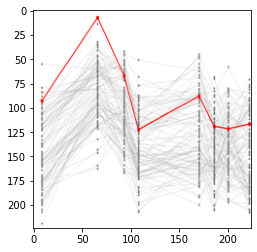

In [112]:
#i=random.randrange(len(test_img))
i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i], test_pred[i],  test_output_df.iloc[i,:])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a